# `microdf` demo

## Setup

In [1]:
import numpy as np
import pandas as pd

import taxcalc as tc
import microdf as mdf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Chart options.

In [2]:
sns.set_style('white')
DPI = 500
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#eeeeee'  # Previously lighter #f5f5f5.

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

## Generate data

In [3]:
base = mdf.calc_df(group_vars=['expanded_income', 'MARS'],
                   metric_vars=['aftertax_income', 'XTOT'])

In [4]:
base.columns

Index(['housing_ben', 'MARS', 'wic_ben', 'other_ben', 'vet_ben', 'e02400',
       'snap_ben', 'mcare_ben', 'tanf_ben', 'mcaid_ben', 'e02300',
       'aftertax_income', 'expanded_income', 'XTOT', 's006', 'ssi_ben',
       'market_income', 'bens', 'tax', 's006_m', 'aftertax_income_m',
       'XTOT_m'],
      dtype='object')

Define a reform that treats capital gains as ordinary income and sets the top marginal rate to 70%.

In [5]:
CG_REFORM = {
    'CG_nodiff': {2019: True},
    'II_rt7': {2019: 0.7}
}

In [6]:
reform = mdf.calc_df(reform=CG_REFORM, group_vars=['MARS'], group_n65=True, 
                     metric_vars=['aftertax_income', 'XTOT'])

In [7]:
reform.columns

Index(['wic_ben', 'e02400', 'snap_ben', 'aftertax_income', 'expanded_income',
       'vet_ben', 'mcaid_ben', 's006', 'housing_ben', 'other_ben', 'mcare_ben',
       'tanf_ben', 'XTOT', 'e02300', 'ssi_ben', 'MARS', 'market_income',
       'bens', 'tax', 'n65', 's006_m', 'aftertax_income_m', 'XTOT_m'],
      dtype='object')

### Calculate senior UBI.

Start with total revenue ($ billions).

In [8]:
new_rev_m = base.aftertax_income_m.sum() - reform.aftertax_income_m.sum()
new_rev_m / 1e3

283.71316097945345

How many seniors are there?

In [9]:
mdf.add_weighted_metrics(reform, 'n65')

n65_total_m = reform.n65_m.sum()
n65_total_m

49.42475809000002

Divide.

In [10]:
senior_ubi = new_rev_m / reform.n65_m.sum()
senior_ubi

5740.304494011401

### Add senior UBI to `aftertax_income` and recalculate

In [11]:
reform['ubi'] = senior_ubi * reform.n65
reform['aftertax_income'] = reform.aftertax_income + reform.ubi
mdf.add_weighted_metrics(reform, 'aftertax_income')

In [12]:
np.allclose(base.aftertax_income_m.sum(), reform.aftertax_income_m.sum())

True

## Analyze

Gini, FPL, distributional impact chart

### Change to Gini index

In [13]:
mdf.gini(base.aftertax_income, base.s006)

0.453761047487913

In [14]:
mdf.gini(reform.aftertax_income, reform.s006)

0.4397329790294458

### Change to poverty rate

Add federal poverty line with `mdf.fpl`.

In [15]:
base['fpl'] = mdf.fpl(base.XTOT)
reform['fpl'] = mdf.fpl(reform.XTOT)

base['fpl_XTOT_m'] = np.where(base.aftertax_income < base.fpl,
                              base.XTOT_m, 0)
reform['fpl_XTOT_m'] = np.where(reform.aftertax_income < reform.fpl,
                                reform.XTOT_m, 0)

In [16]:
reform.fpl_XTOT_m.sum() / base.fpl_XTOT_m.sum() - 1

-0.007277782415314404

Add chart.

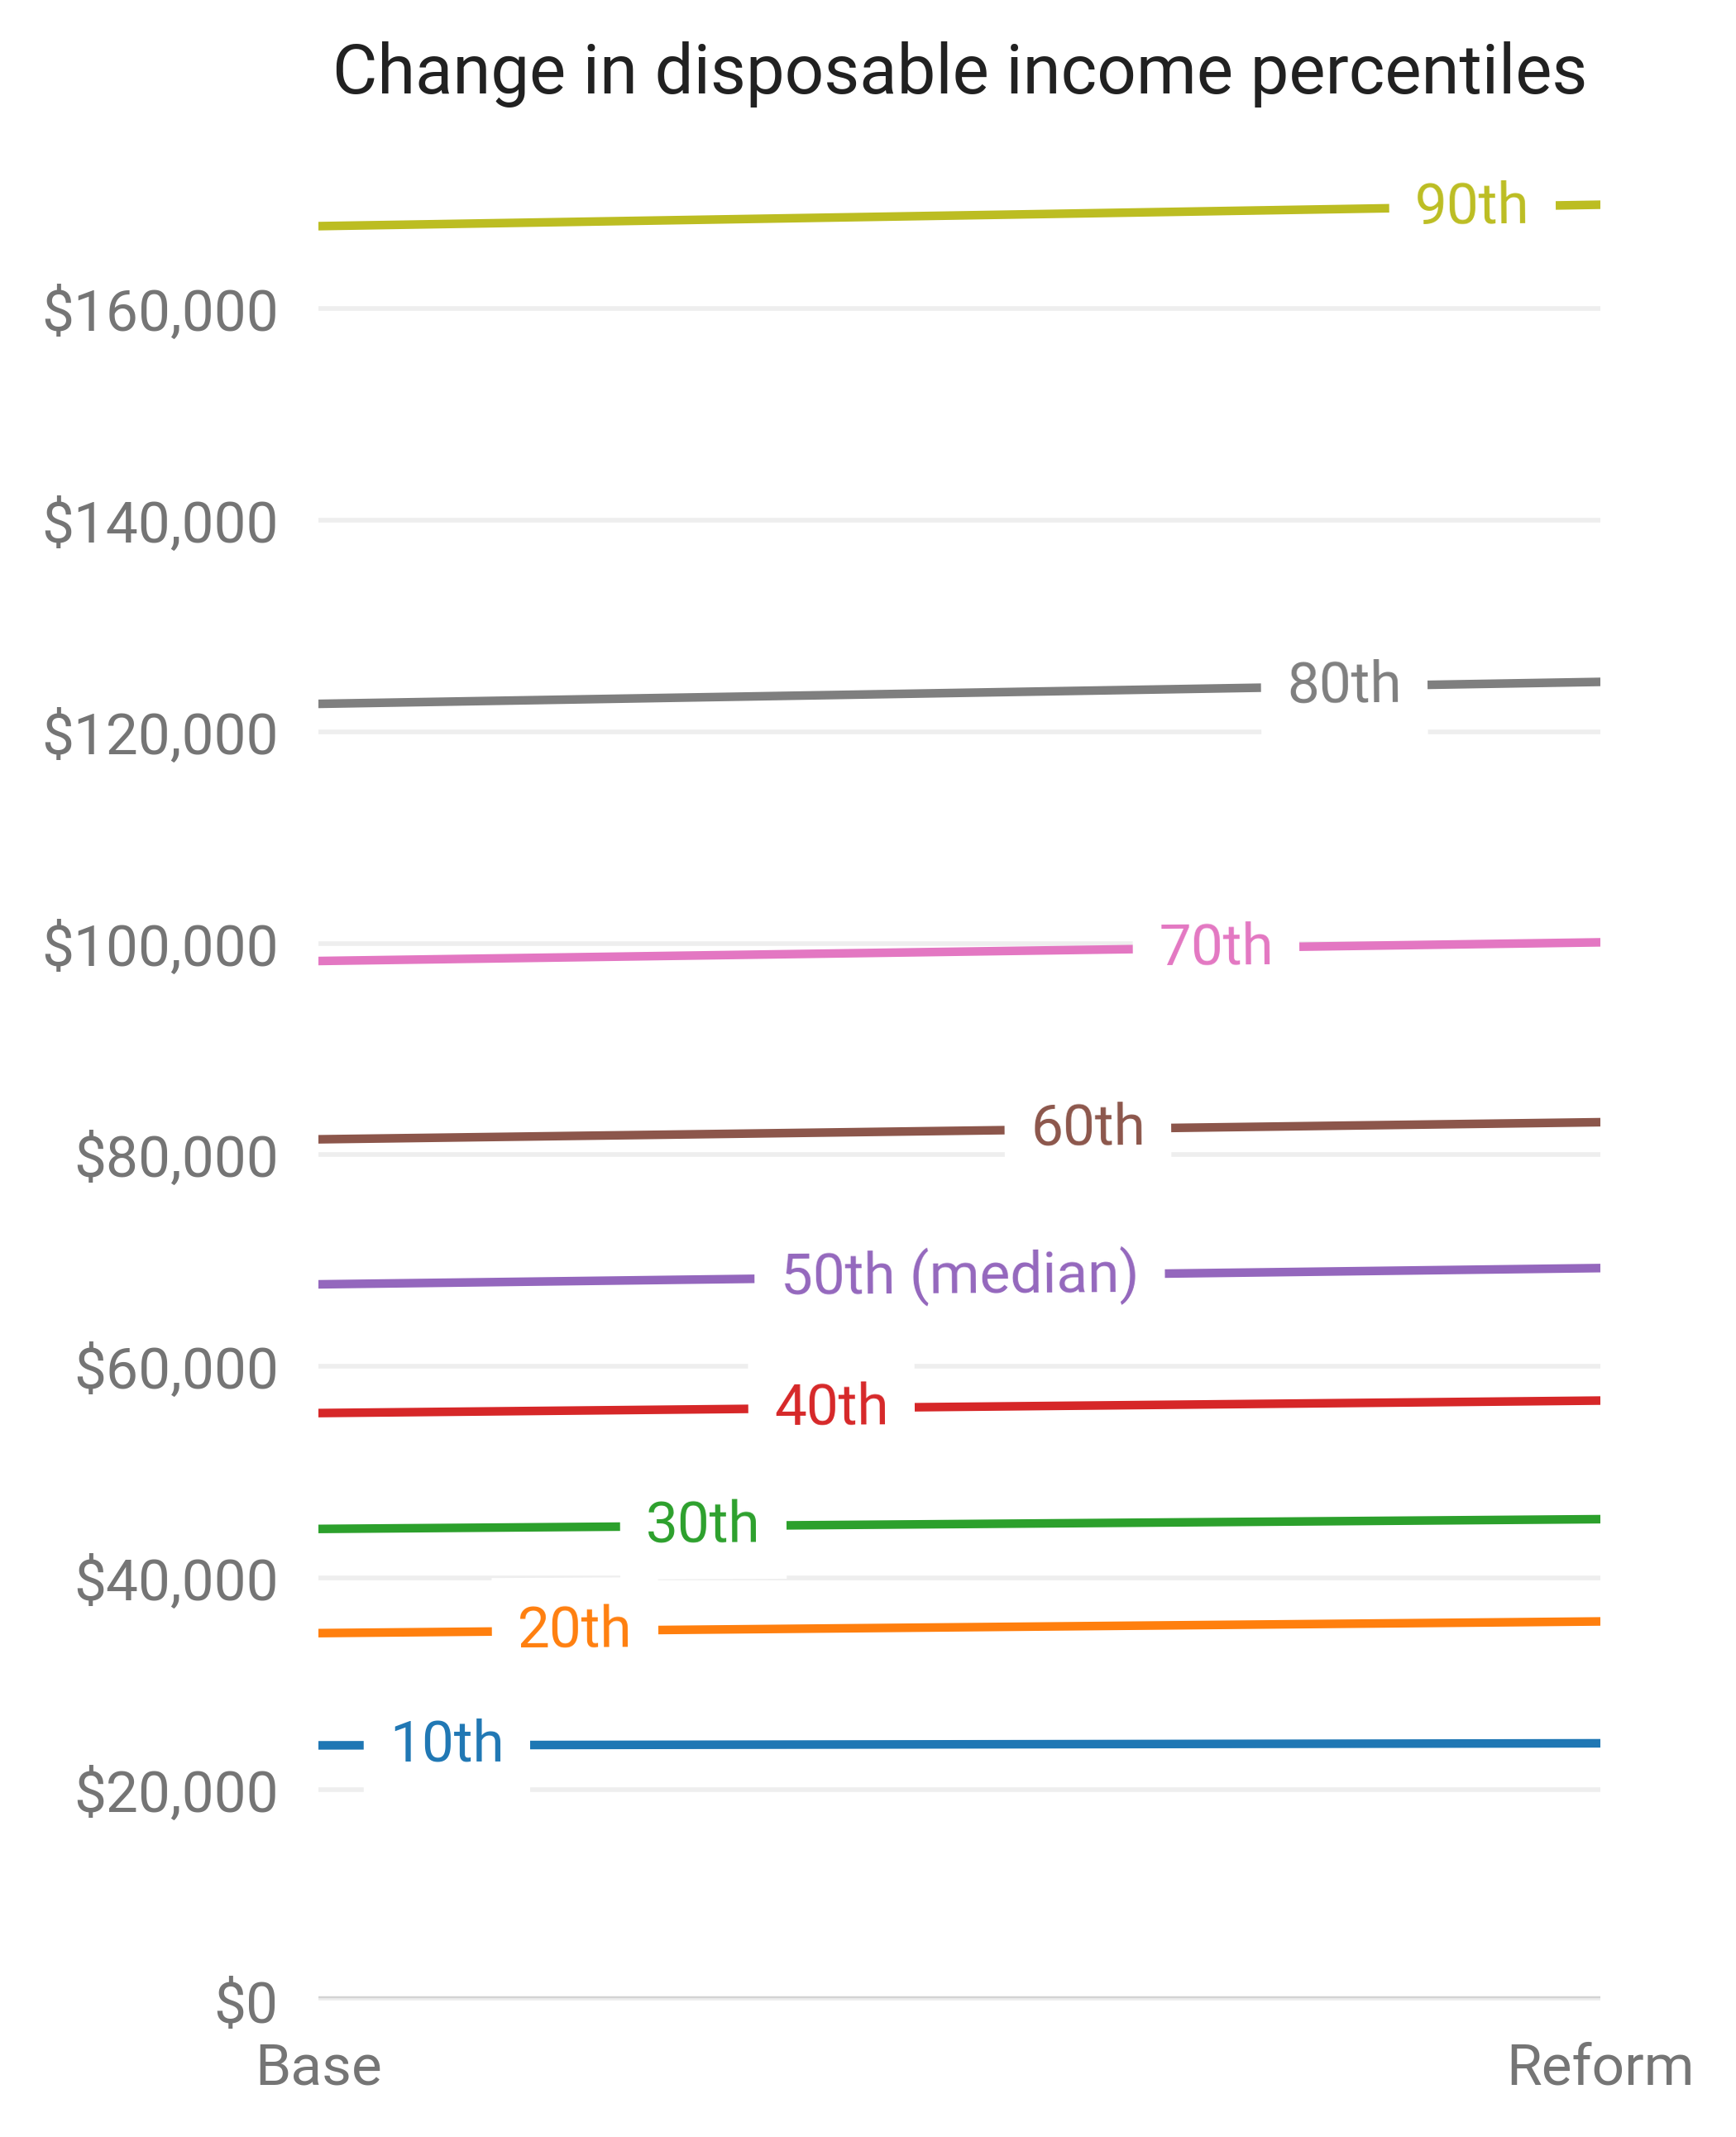

In [17]:
ax = mdf.quantile_chg_plot(base.aftertax_income, reform.aftertax_income,
                           base.XTOT_m, reform.XTOT_m)